# 基于 VGG 的 FashionMNIST 数据集的分类
## 1. 导入 FashionMNIST 数据集
首先我们下载 FashionMNIST 数据集， 这需要定义一个导入函数 load_FashionMNIST_dataset

In [1]:
"""
    Date: 2022-12-05
    Author: Kingsley Cheng
    Tag: VGG(FashionMNIST)
"""

# imports
import torch
from torch import nn
from torch import optim
from torch.utils import data

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("./runs/FashionMNIST/VGG")

import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# dataset path
ROOT = "./data"
# model path
PATH = "./model/VGG"
BatchSize = 256
labels = np.array(['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot'])

# help function
def load_FashionMNIST_datasets(batchsize, root=ROOT):
    """
    help function to load FashionMNIST datasets
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize(0.5,0.5),])
    
    # trainsets
    trainsets = torchvision.datasets.FashionMNIST(root=root,train=True,transform=transform,download=True)
    tranloader = data.DataLoader(trainsets,batch_size=batchsize, shuffle=True, num_workers=2)
    
    # testsets
    testsets = torchvision.datasets.FashionMNIST(root=root, train=False, transform=transform, download=True)
    testloader = data.DataLoader(testsets, batch_size=batchsize, shuffle=False, num_workers=2)

    return tranloader, testloader

创建一个图像输出函数 imshow()，用于将读取到的样本转化为图像。

In [2]:
# help function
def imshow(imgs):
    """
    help function to print images
    """
    # Unnormalized
    imgs = imgs/2 +0.5
    npimg = imgs.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

下面我们下载 FashionMNIST 数据集并读取其中几个样本，打印出来观察一下。

['shirt' 't-shirt' 'trouser' 'shirt' 'shirt' 'shirt' 't-shirt' 'pullover']


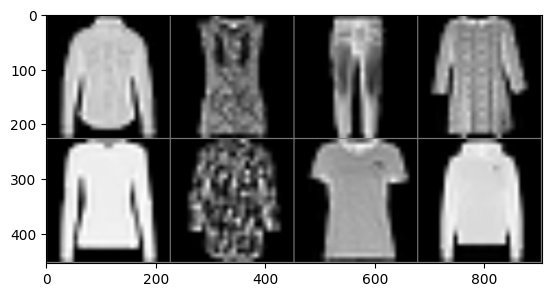

In [3]:
trains, tests = load_FashionMNIST_datasets(batchsize=BatchSize)
trainiter = iter(trains)
X, y = next(trainiter)

img_grid = torchvision.utils.make_grid(X[:8],nrow=4)
imshow(img_grid)
print(labels[y[:8]])

# write to TensorBoard
writer.add_images("Some samples", X[:8])
writer.close()

## 2.建立 VGG

### 基本架构：
VGG 相较于 AlexNet 使用了模块化设计，通过定义 VGG 块可以进行重复堆叠，从而进一步加深网络层数。

输入：图片（$3\times 224\times 224$）

模块一：

1. 
- $3\times 3$ 卷积层（64）,填充为 1
- ReLU 函数激活
- $2\times 2$ 最大汇聚层，步幅为 2 （64@112*112）
2. 
- $3\times 3$ 卷积层（128）,填充为 1
- ReLU 函数激活
- $2\times 2$ 最大汇聚层，步幅为 2 （128@56*56）

模块二：

3. 
- $3\times 3$ 卷积层（256）,填充为 1
- ReLU 函数激活
- $3\times 3$ 卷积层（256）,填充为 1
- ReLU 函数激活
- $2\times 2$ 最大汇聚层，步幅为 2 （256@28*28）

4. 
- $3\times 3$ 卷积层（512）,填充为 1
- ReLU 函数激活
- $3\times 3$ 卷积层（512）,填充为 1
- ReLU 函数激活
- $2\times 2$ 最大汇聚层，步幅为 2 （512@14*14）

5. 
- $3\times 3$ 卷积层（512）,填充为 1
- ReLU 函数激活
- $3\times 3$ 卷积层（512）,填充为 1
- ReLU 函数激活
- $2\times 2$ 最大汇聚层，步幅为 2 （512@7*7）

6. 
- Flatten 展平
- 全连接层（512\*7*7,4096）
- ReLU 函数激活
- Dropout(0.5)
- 全连接层（4096，4096）
- ReLU 函数激活
- Dropout(0.5)
- 全连接层（4096，1000）
- softmax 函数分类输出

输出：1000 个类别样本

### 创新特点
1. 使用了 VGG 块，标志着卷积神经网络从层状向块状发展。

In [4]:
def vgg_block(num_convs, in_channels, out_channels):
    """
    VGG Block:
    inputs: num_convs, in_channels, out_channels
    outputs: VGG Block
    """
    layers = []
    for _ in range(num_convs):
        layers.append(
            nn.Conv2d(kernel_size=3, padding=1,in_channels=in_channels,out_channels=out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)


# Construct VGG-11 
def VGG11(conv_arch):
    """
    VGG-11
    inputs: net structure
    output: VGG-11
    """
    conv_blks = []
    in_channels = 1
    # Conv Part
    for (num_convs,out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    # Add Linear Part
    return nn.Sequential(
        *conv_blks,
        nn.Flatten(),
        nn.Linear(out_channels*7*7, 4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,4096),
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(4096,10))

conv_arch = ((1,64),(1,128), (2,256), (2,512), (2,152))
vgg11 = VGG11(conv_arch)

# write to TensorBoard
writer.add_graph(vgg11, X)
writer.close()

In [8]:
def try_gpu():
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

In [5]:
def train(net,criterion,optimizer,trainsets,device,epochs=3):
    """
    function to train VGG-11
    """

    # init function
    def init_weights(m):
        """
        function to init net parameters weight
        """
        if type(m) == nn.Conv2d or type(m) == nn.Linear:
            nn.init.xavier_normal_(m.weight)
    
    net.apply(init_weights)

    net.to(device)
    print("Training on!")
    for epoch in tqdm(range(epochs)):
        running_loss = 0.0
        net.train()
        loop = tqdm(trainsets, desc=f"Train{epoch+1}")
        for i,(X, y) in enumerate(loop):
            optimizer.zero_grad()
            X,y = X.to(device), y.to(device)
            outputs = net(X)
            loss = criterion(outputs, y)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
        print(f"epoch {epoch+1}, avg_loss: {running_loss/i}")
    print("Finish Training!")
    return net.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg11.parameters(),lr=0.05,momentum=0.9)
vgg11 = train(vgg11,criterion,optimizer,trains,try_gpu(),1)
torch.save(vgg11, PATH)

Training on!


  0%|          | 0/1 [00:00<?, ?it/s]

Train1:   0%|          | 0/235 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
vgg11 = torch.load(PATH,map_location=try_gpu())